# Multilayer perceptron example

The model aims to "learn" from the past data 2015 to 2022 the daily dynamics of the Net Ecosystem Exchange (NEE) that tells "how much carbon was taken up by the forest in Järvselja" in time steps of 30 minutes. And also what might be the temperature dynamics over a day.

The model can then be used to make some predictions on future days.

- - -
This notebook was tested with PyTorch 2.2.1 and Python 3.10.9 on a MacBook pro M2 Max 

The code shoud be executable in Jupyter notebook environments (Jupyter Docker Stacks), Google Colab, ...)


In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

torch.__version__

'2.2.1'

### Create device agnostic code

The variable device will keep track of a possible GPU device. 

Supported:
- CUDA: NVidia GPU's
- MPS : Apple Silicon GPU's
- CPU : fallback if there is no GPU available

In [123]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


### Loading data from repository

The next cells show examples how to load data from a GitHub repository. 

#### Version 1: 
This is the shortest way to load data directly into a dataframe. However, it will load the data any time the script is executed and slows down processing depending on the access speed.


In [225]:
# Read data file from GitHub
# df = pd.read_csv("https://raw.githubusercontent.com/stenoe/IoT/main/Data/k3s-iot-2024/NEE_data.csv")
# df.head()

,timestamp,Year,Month,Day,Hour,DoY,Tair_f,NEE_f,GPP_f,Reco
0,2015-01-01 02:30:00,2015,1,1,2.5,1,3.951,0.82133,0.440330,1.261665
1,2015-01-01 03:00:00,2015,1,1,3.0,1,4.152,0.14769,1.127700,1.275359
2,2015-01-01 03:30:00,2015,1,1,3.5,1,4.182,0.94247,0.334930,1.277406
3,2015-01-01 04:00:00,2015,1,1,4.0,1,4.071,1.24960,0.020266,1.269836
4,2015-01-01 04:30:00,2015,1,1,4.5,1,3.878,0.71517,0.541530,1.256700


#### Version 2:

This version is first testing if the data file is already locally available, if not it will download it and save it to the current folder. If the script is executed many times, then this way the downlad happens only once and the local file is used after. This gives advantage in execution speed. 

In [227]:
# Load data from GitHub and save to file locally
import requests

from pathlib import Path

# download data from repo (if it doesn't already exists)
if Path("NEE_data.csv").is_file():
  print("NEE_data.csv already exists, skipping download")
else:
  print("Download data...")
  request = requests.get("https://raw.githubusercontent.com/stenoe/IoT/main/Data/k3s-iot-2024/NEE_data.csv")
  with open("NEE_data.csv", "wb") as f:
    f.write(request.content)

df = pd.read_csv("NEE_data.csv")
df.head()

Download data...


,timestamp,Year,Month,Day,Hour,DoY,Tair_f,NEE_f,GPP_f,Reco
0,2015-01-01 02:30:00,2015,1,1,2.5,1,3.951,0.82133,0.440330,1.261665
1,2015-01-01 03:00:00,2015,1,1,3.0,1,4.152,0.14769,1.127700,1.275359
2,2015-01-01 03:30:00,2015,1,1,3.5,1,4.182,0.94247,0.334930,1.277406
3,2015-01-01 04:00:00,2015,1,1,4.0,1,4.071,1.24960,0.020266,1.269836
4,2015-01-01 04:30:00,2015,1,1,4.5,1,3.878,0.71517,0.541530,1.256700


### Make a trainig and testing dataset

In [213]:
RANDOM_SEED = 42

# Create X data features from df, use the standard scaler
X = df[["Year", "Month", "Day", "Hour", "DoY"]].values
scaler = StandardScaler().fit(X)
X = torch.tensor(scaler.transform(X)).to(torch.float32)

# Create y data labels from df
# y = torch.tensor(df.NEE_f.values).to(torch.float32)
y = torch.tensor(df[["Tair_f", "NEE_f"]].values).to(torch.float32)

# Make the train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED)

print(X_train[:5], y_train[:5])
print(X_test[:5], y_test[:5])

tensor([[ 1.4998, -0.4415,  0.0306,  0.5414, -0.4471],
        [ 1.4998, -0.7314,  0.5987,  1.6242, -0.6842],
        [-1.0001, -0.7314,  0.7123, -0.3248, -0.6652],
        [-1.0001, -1.3113, -1.2193,  0.8301, -1.3954],
        [ 1.4998, -0.1515, -1.4466,  0.0361, -0.2764]]) tensor([[ 20.1310,  -4.9843],
        [  7.0240,   1.5010],
        [  6.4630,  -8.4150],
        [  0.3670,   0.8489],
        [ 19.6930, -13.8510]])
tensor([[-1.5001, -0.7314,  0.5987, -0.9023, -0.6842],
        [-1.0001,  0.7184, -0.9921, -0.3248,  0.6435],
        [ 0.4998,  0.1385, -0.9921,  0.1805,  0.0461],
        [ 1.4998, -0.4415,  0.2578, -0.0361, -0.4281],
        [-0.5001, -0.4415,  0.3715,  0.3248, -0.4186]]) tensor([[ 5.2300e+00,  1.2884e+00],
        [ 1.5846e+01, -1.2284e-02],
        [ 1.3620e+01, -7.6119e+00],
        [ 1.2003e+01, -3.7920e+00],
        [ 2.2961e+01, -7.1301e+00]])


### Build a MLP (multilayer perceptron) model

The model will use 5 input features, two output features, 20 hidden units. It is organised into 3 layers and uses ReLU as activation between the layers.

In [214]:
# Build a MLP-model with non-linear activiation function
from torch import nn

class ModelV1(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=50):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_0 = ModelV1(input_features=5, 
                       output_features=2,
                       hidden_units=20
                      ).to(device)

model_0

ModelV1(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [215]:
# Create the loss func and optimiser
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.L1Loss()
optimiser = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

In [216]:
# Calculate accuracy -  out of 100 examples, what does the model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

### Different accuracy functions

In the 1.x version of PyTorch, the BinaryAccuracy didn't work for the Apple Silicon GPUs. This has been solved by the new 2.x versions.

In [217]:
# enable torchmetrics accuracy
from torchmetrics.classification import BinaryAccuracy
#from torchmetrics.classification import Accuracy

torchmetric_accuracy = BinaryAccuracy().to(device)
#torchmetric_accuracy = Accuracy(task="binary").to(device)
### NOTE: PyTorch MPS lacks a aten::unique2 implementation! Therefore Accuracy fails on Apple silicon GPUs using torch 1.3.1
### NOTE: Problem is fixed in torch 2.2.1, BinaryAccuracy works fine

In [218]:
# Create the training and testing loop

torch.manual_seed(RANDOM_SEED)
if device == "cuda":
    torch.cuda.manual_seed(RANDOM_SEED)

# Put all tensors to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
epochs = 1000 # number of passes through the data

for epoch in range(epochs):
    ### Train
    model_0.train()
    
    # forward pass
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    # loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)
    #acc = torchmetric_accuracy(y_train, y_preds)
    
    # zero grad / backpropagation / step
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
    ### Test
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        # test_preds = torch.round(torch.sigmoid(test_logits))
        # test_preds = test_logits
        test_loss = loss_fn(test_logits, y_test)
        # test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)
        # test_acc = torchmetric_accuracy(y_test, y_preds)
        
    # Print what's happenin'
    if epoch % 100 == 0:
        # print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Test loss: {test_loss:.4f}")
    
    

Epoch: 0 | Loss: 6.4993 | Test loss: 6.4750
Epoch: 100 | Loss: 5.9185 | Test loss: 5.8864
Epoch: 200 | Loss: 5.1944 | Test loss: 5.1686
Epoch: 300 | Loss: 4.5921 | Test loss: 4.5611
Epoch: 400 | Loss: 3.8042 | Test loss: 3.7786
Epoch: 500 | Loss: 3.1219 | Test loss: 3.1042
Epoch: 600 | Loss: 2.8055 | Test loss: 2.7921
Epoch: 700 | Loss: 2.6451 | Test loss: 2.6324
Epoch: 800 | Loss: 2.5613 | Test loss: 2.5496
Epoch: 900 | Loss: 2.5281 | Test loss: 2.5184


In [219]:
# evaluation and predictions
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test).squeeze()
    
y_preds[:-1], y_test[:10]

(tensor([[  4.7275,   1.1235],
         [ 14.2323,  -5.1918],
         [ 21.6633, -14.0861],
         ...,
         [ 13.8565,   3.3052],
         [  6.0463,   1.6201],
         [  0.8460,   0.6575]], device='mps:0'),
 tensor([[ 5.2300e+00,  1.2884e+00],
         [ 1.5846e+01, -1.2284e-02],
         [ 1.3620e+01, -7.6119e+00],
         [ 1.2003e+01, -3.7920e+00],
         [ 2.2961e+01, -7.1301e+00],
         [ 3.2960e+00,  1.5605e+00],
         [ 1.4438e+01,  4.5761e+00],
         [ 1.6226e+01, -8.8323e+00],
         [ 3.4440e+00,  2.7049e-01],
         [-8.0800e-01,  1.3179e+00]], device='mps:0'))

### Prediction constants


$\color{green}{\text{Here you can play with the date}}$

In [220]:
# Set some DOY and YEAR to predict
YEAR = 2024
MONTH = 8
DAY = 15

# Create a dataframe with the date and get the day of year
ddf = pd.DataFrame({"Year": [YEAR], "Month": [MONTH], "Day": [DAY]})
ddf["DoY"] = pd.to_datetime(ddf[["Year", "Month", "Day"]]).dt.dayofyear
DOY = ddf["DoY"].values[0] 
DOY

228

In [221]:
model_0.eval()
result = []
xframe = []
with torch.inference_mode():
    
    hh = df.Hour.unique().tolist()
    hh.sort()
    
    for i in hh:
        xframe.append([YEAR, MONTH, DAY, i, DOY])
        xin = np.array([YEAR, MONTH, DAY, i, DOY]).reshape(1, -1)
        Xu = torch.tensor(scaler.transform(xin)).to(torch.float32)
        predu = model_0(Xu.to(device)).squeeze()
        result.append(predu.cpu().numpy())

# result

In [222]:
rf = pd.DataFrame(result, columns = ["Tair", "NEE"])
dfx = pd.DataFrame(xframe, columns = ["Year", "Month", "Day", "Hour", "DoY"])

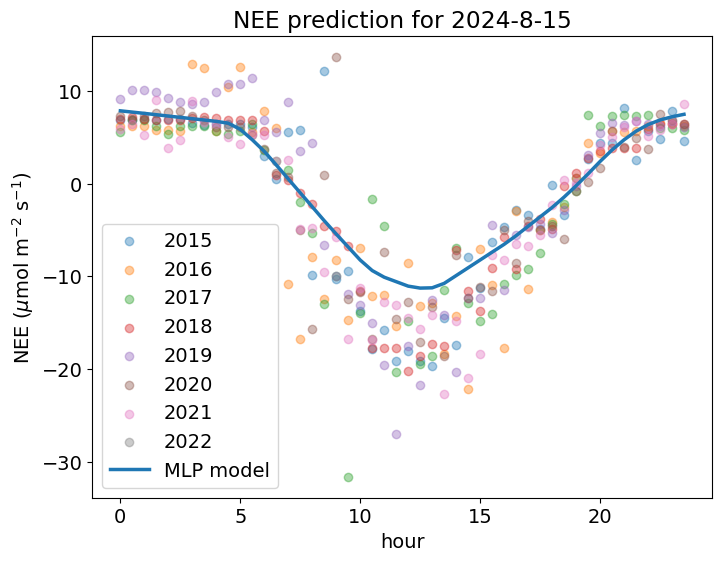

In [223]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8, 6))

for i in df.Year.unique():
    plt.scatter(df[(df.Year==i) & (df.DoY==DOY)].Hour, df[(df.Year==i) & (df.DoY==DOY)].NEE_f, alpha=0.4, label=i)

plt.plot(dfx.Hour, rf.NEE, linewidth=2.5, label="MLP model")

plt.title(f"NEE prediction for {YEAR}-{MONTH}-{DAY}")
plt.xlabel("hour")
plt.ylabel("NEE ($\mu$mol m$^{-2}$ s$^{-1}$)")
plt.legend(loc='lower left')
plt.show()

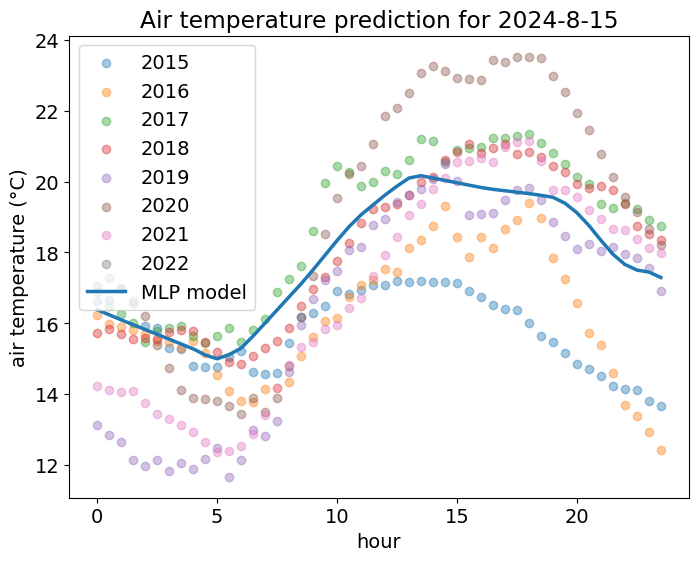

In [224]:
plt.figure(figsize=(8, 6))

for i in df.Year.unique():
    plt.scatter(df[(df.Year==i) & (df.DoY==DOY)].Hour, df[(df.Year==i) & (df.DoY==DOY)].Tair_f, alpha=0.4, label=i)

plt.plot(dfx.Hour, rf.Tair, linewidth=2.5, label="MLP model")

plt.title(f"Air temperature prediction for {YEAR}-{MONTH}-{DAY}")
plt.xlabel("hour")
plt.ylabel("air temperature (°C)")
plt.legend(loc='upper left')
plt.show()